# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
# From https://stackoverflow.com/questions/48875783/how-to-upload-many-files-to-google-colab
# Needed to be able to access CIFAR-10 data saved on my Google Drive
# Cell not needed to be run each time Colab notebook is opened but seems to be needed when notebook opened for first time in a while

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive

In [3]:
# Checking to see if directories on my Google Drive are accessible
!ls Drive/CS231n

Assignment_1


In [0]:
# Trying to import python modules from files stored on my Google Drive
# Following example here: http://www.pingshiuanchua.com/blog/post/importing-your-own-python-module-or-python-file-in-colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data_utils_module = drive.CreateFile({'id':'1Dxb8NfzUDqtRC3uNt_bRX4_Y3j5rHIZu'})
data_utils_module.GetContentFile('data_utils.py')

import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    #cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    cifar10_dir = 'Drive/CS231n/Assignment_1/cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

softmax_module = drive.CreateFile({'id':'1NvoZa_LkC_fftCtL5wCppw-9HEq-Fyxo'})
softmax_module.GetContentFile('softmax.py')

#from cs231n.classifiers.softmax import softmax_loss_naive
from softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.357829
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Before training and with W initialized randomly, cross-entropy loss is approximately given by -1*ln(1/C) = ln(C), with C equal to number of classes.


In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
gradient_check_module = drive.CreateFile({'id':'1GZ4Ls9pFWKeBX-e6AB-UZ-lAvy21ncpR'})
gradient_check_module.GetContentFile('gradient_check.py')

#from cs231n.gradient_check import grad_check_sparse
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.622487 analytic: -2.622487, relative error: 3.350552e-08
numerical: -1.648044 analytic: -1.648044, relative error: 2.369439e-08
numerical: 2.035078 analytic: 2.035078, relative error: 4.501756e-09
numerical: 1.022296 analytic: 1.022296, relative error: 6.624959e-08
numerical: 1.154930 analytic: 1.154930, relative error: 4.417714e-08
numerical: 2.303380 analytic: 2.303380, relative error: 1.402264e-08
numerical: 1.807675 analytic: 1.807675, relative error: 2.356219e-08
numerical: 0.404294 analytic: 0.404294, relative error: 1.727920e-07
numerical: 2.087821 analytic: 2.087820, relative error: 3.864885e-08
numerical: -0.685762 analytic: -0.685762, relative error: 6.549177e-08
numerical: -0.565892 analytic: -0.565892, relative error: 1.569155e-07
numerical: -1.563005 analytic: -1.563005, relative error: 3.103344e-08
numerical: 2.453555 analytic: 2.453555, relative error: 1.558866e-09
numerical: -1.202578 analytic: -1.202578, relative error: 6.259157e-08
numerical: -1.550343 a

In [9]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from cs231n.classifiers.softmax import softmax_loss_vectorized
from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.357829e+00 computed in 0.225382s
vectorized loss: 2.357829e+00 computed in 0.015486s
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

linear_svm_module = drive.CreateFile({'id':'1pM1Q2ciIu8mGgYOe3V-HGC8aMpEQvpGd'})
linear_svm_module.GetContentFile('linear_svm.py')
from linear_svm import *

linear_classifier_module = drive.CreateFile({'id':'17rYYuBbRyUGsf0cHelmDu6NjS5ci-tyV'})
linear_classifier_module.GetContentFile('linear_classifier.py')
from linear_classifier import Softmax

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]


import itertools

for lr_rs_pairs in itertools.product(learning_rates, regularization_strengths):
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr_rs_pairs[0], reg=lr_rs_pairs[1], num_iters=1500, batch_size=200)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(lr_rs_pairs[0], lr_rs_pairs[1])] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = softmax


# Print out results.
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e rs %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 rs 1.000000e+04 train accuracy: 0.141776 val accuracy: 0.139000
lr 1.000000e-08 rs 2.000000e+04 train accuracy: 0.163163 val accuracy: 0.163000
lr 1.000000e-08 rs 3.000000e+04 train accuracy: 0.164592 val accuracy: 0.181000
lr 1.000000e-08 rs 4.000000e+04 train accuracy: 0.167959 val accuracy: 0.154000
lr 1.000000e-08 rs 5.000000e+04 train accuracy: 0.172122 val accuracy: 0.186000
lr 1.000000e-08 rs 6.000000e+04 train accuracy: 0.178204 val accuracy: 0.174000
lr 1.000000e-08 rs 7.000000e+04 train accuracy: 0.188878 val accuracy: 0.195000
lr 1.000000e-08 rs 8.000000e+04 train accuracy: 0.207306 val accuracy: 0.203000
lr 1.000000e-08 rs 1.000000e+05 train accuracy: 0.220367 val accuracy: 0.221000
lr 1.000000e-07 rs 1.000000e+04 train accuracy: 0.333286 val accuracy: 0.317000
lr 1.000000e-07 rs 2.000000e+04 train accuracy: 0.351102 val accuracy: 0.371000
lr 1.000000e-07 rs 3.000000e+04 train accuracy: 0.344163 val accuracy: 0.352000
lr 1.000000e-07 rs 4.000000e+04 train ac

In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.378000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: Softmax classifier loss incorporates all scores in normalization used to convert scores to probabilities--this means addition of new point will change loss function, even if only slightly.  If the new data point is easily classified by an SVM (i.e., score for correct class is above all other scores in excess of the margin), then this new data point will not contribute to the SVM loss.

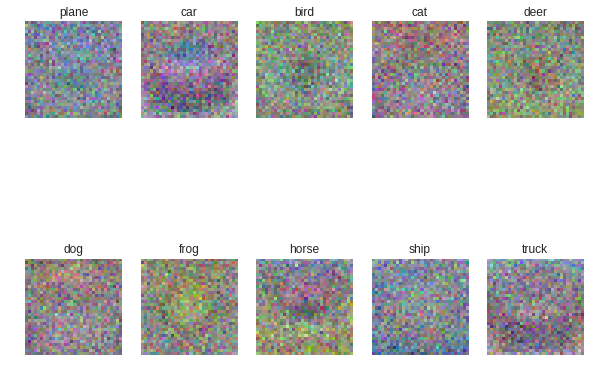

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])